In [2]:
%pip install pyspark

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pyspark 
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import numpy as np
import random

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm

from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = '1'

/Users/camillabrigandi/anaconda3/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [4]:
merged_df = pd.read_json('allvariables.json', lines=True)
merged_df

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0
161914,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0
161915,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0
161916,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0


In [5]:
# Creating Spark session
spark=SparkSession.builder.appName('HW4').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/11 18:37:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
# Read data from the pca and save it as Pyspark sql dataframe (done in order to get rdds from the dataframes)
df_pysparkpca3 = spark.read.option('header','true').json('reduced3.json')
df_pysparkpca9 = spark.read.option('header','true').json('reduced9.json')
df_pysparkpca9.printSchema() # See column names and data tipes, similar to df.info() for pandas dataframes 

#Create RDD from dataframe 
dfrddpca3 = df_pysparkpca3.rdd 
dfrddpca9 = df_pysparkpca9.rdd 


root
 |-- 0: double (nullable = true)
 |-- 1: double (nullable = true)
 |-- 2: double (nullable = true)
 |-- 3: double (nullable = true)
 |-- 4: double (nullable = true)
 |-- 5: double (nullable = true)
 |-- 6: double (nullable = true)
 |-- 7: double (nullable = true)
 |-- 8: double (nullable = true)



## 2.3 Clustering!


### 2.3.1: Implement K-means using MapReduce

In [7]:
def extract_starting_centroids(rdd, k):
    #returns k samples extracted from our dataset(in rdd form) without replacement
    return rdd.takeSample(False, k)

def euclidean_squared_distance(x, y):
    x = np.array(x, dtype=np.float64)
    y = np.array(y, dtype=np.float64)
    return (np.linalg.norm(x-y))**2

checkconvergencefun = lambda l1, l2: sum(sum([el1 - el2 for (el1, el2) in zip(l1, l2)]))

In [8]:
def Kmeans(rdd_data, centroids, k, it):
    niter = it
    # MAP PHASE
    rddmap = rdd_data.map(lambda point:(np.argmin([ euclidean_squared_distance(point, centroid) for centroid in centroids ]), (point, 1)))

    # REDUCE PHASE
    rddreduce = rddmap.reduceByKey(lambda t1, t2: (np.add(t1[0], t2[0]), t1[1] + t2[1]) )

    # COMPUTE THE NEW CENTROIDS 
    new_centroids = rddreduce.mapValues(lambda t: t[0]/t[1]).map(lambda t: t[1])
    new_centr_list = new_centroids.collect()

    # CHECKING CONVERGENCE 
    if checkconvergencefun([np.array(centroid) for centroid in centroids], new_centr_list) == 0:
        # Compute the clusters (do we need to do that?)
        clusters = rddmap.groupByKey().sortByKey().mapValues(lambda iterable: [t[0] for t in list(iterable)]).collect()
        clusters_idx  = rddmap.map(lambda t: t[0]).collect()
        return clusters, clusters_idx, new_centr_list, niter
    else:
        niter += 1
        return Kmeans(rdd_data, new_centr_list, k, niter)



### 2.3.2: Find an optimal number of clusters using at least two different methods.

*Method 1*: Elbow method

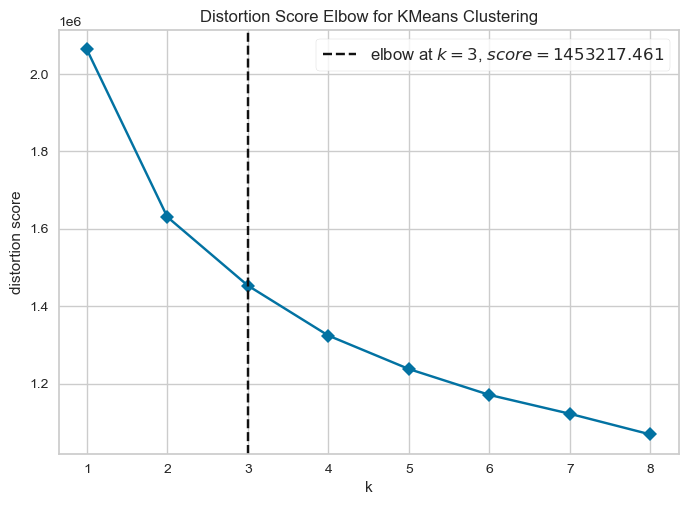

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# Reading data from the PCA
data = pd.read_json('reduced9.json', lines=True)

# Inintialize clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 9),  timings=False, locate_elbow=True) #not showing the time cause it's not relevant since we won't be using the pre . implemented Kmeans algorithm to cluster

# Fit the model 
visualizer.fit(data)  

# Show results
visualizer.show()

**Method 2. Silhouette coefficient**

100%|██████████| 8/8 [00:14<00:00,  1.83s/it]


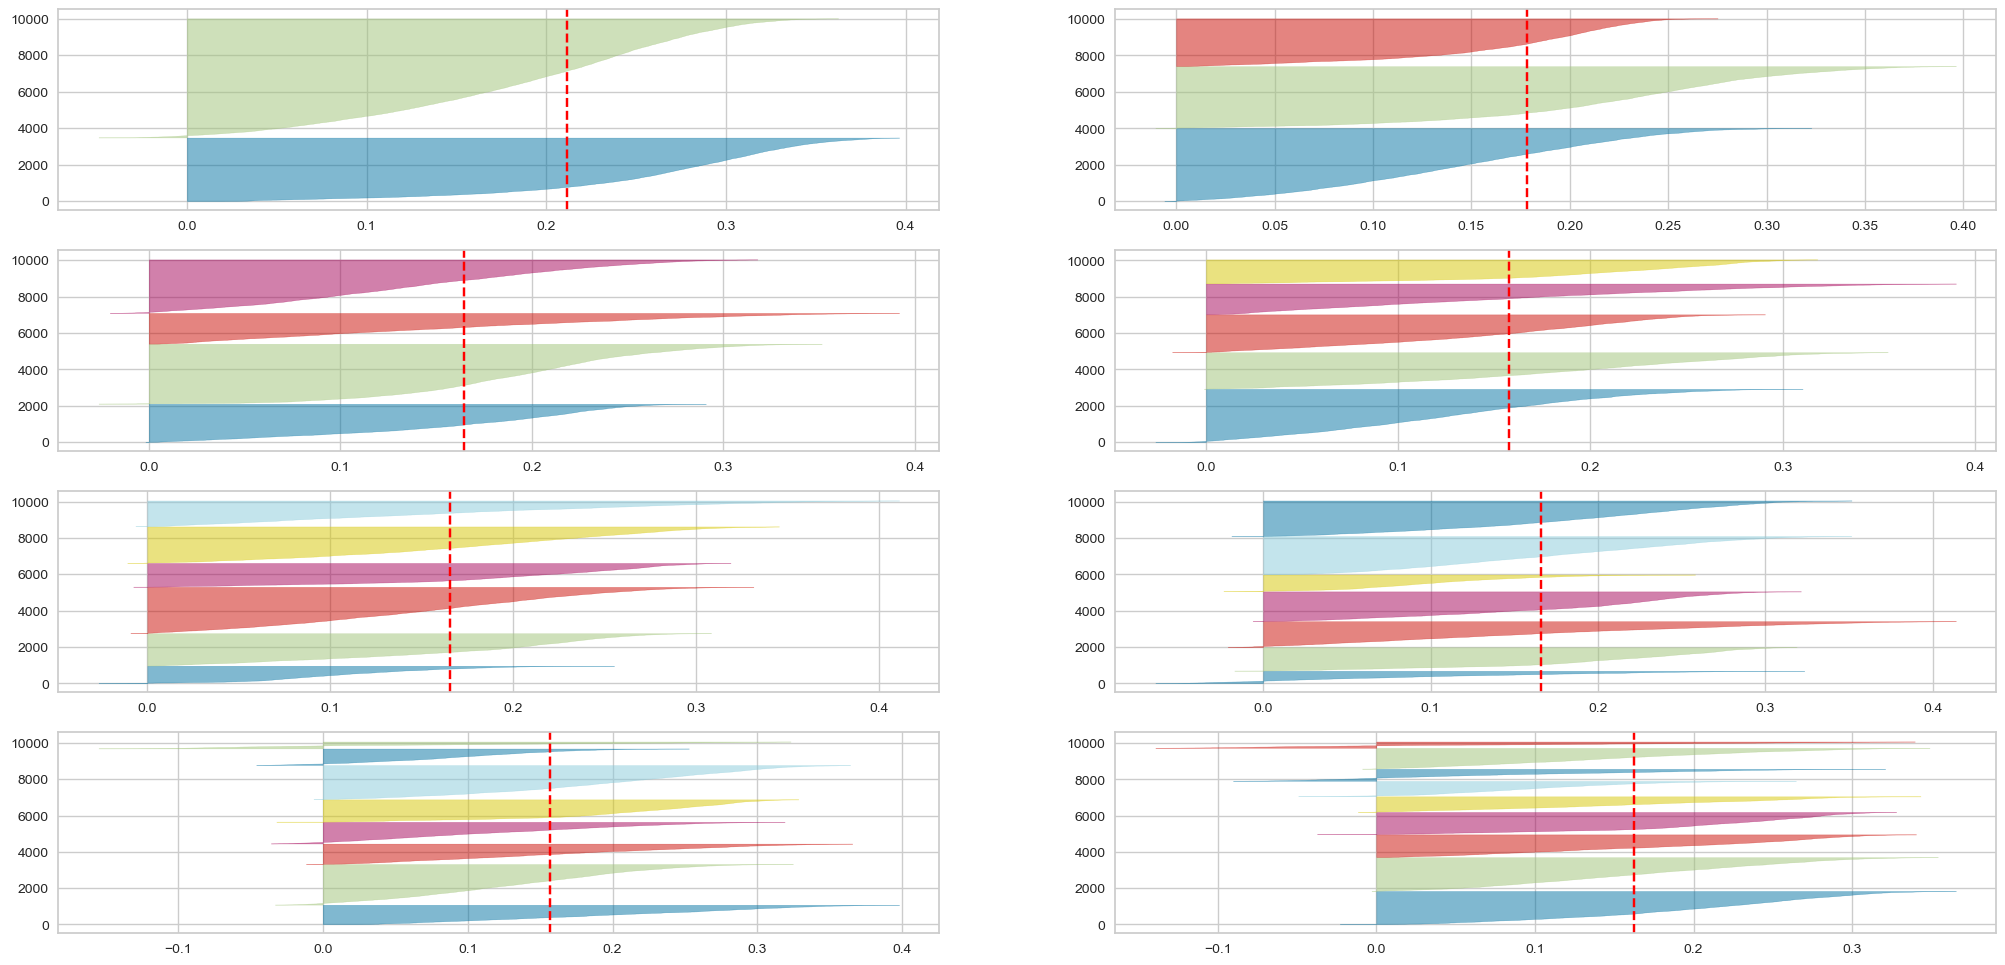

In [11]:
# Reading data from the pca and taking a sample of it to see the Silhouette score due to computational reasons
data= pd.read_json('reduced9.json', lines=True)
sample = data.sample(n = 10000)

# Setting plot structure
fig, ax = plt.subplots(4, 2, figsize=(25, 12))

for i in tqdm(range(2, 10)):
    # Performing clustering using the pre-implemented Kmeans algorithm and fixing the number of clusters to i 
    km = KMeans(n_clusters=i, n_init=10, max_iter=100, random_state=42)

    # Initializing the visualizer for the silhouette score
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    
    # Computing Silhouette score and visualizing the results 
    visualizer.fit(sample)

k = 2 for the Silhouette svore, even tough the clusters are not really there(see the scatterplot for the first 2 principal components)

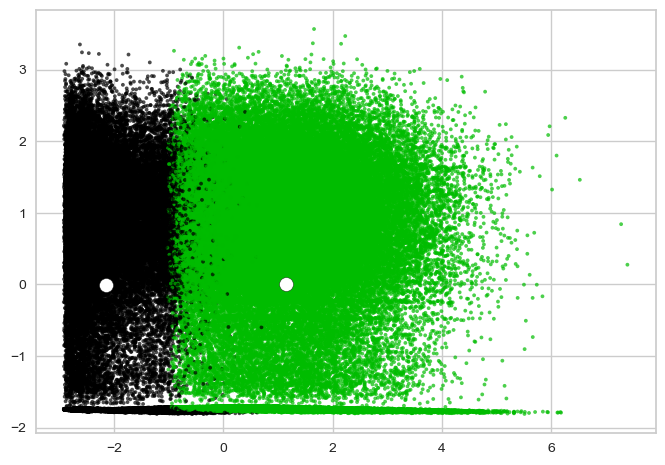

In [33]:
data=pd.read_json('reduced9.json', lines=True)
datav = data.values
fig, ax2 = plt.subplots(1, 1)
n_clusters = 2
clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
cluster_labels = clusterer.fit_predict(data)

colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    
ax2.scatter(
        datav[:, 0], datav[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=100,
    edgecolor="k",
)

### 2.3.3: Run the algorithm on the data obtained from the dimensionality reduction.

In [13]:
#results - PCA 9, Kmeans 
centroids = extract_starting_centroids(dfrddpca9, 2)
_, keys9, centroids,  niter9  = Kmeans(dfrddpca9, centroids, 2, 0)

#Insert cluster label in the original dataframe
dftotal9 = pd.read_json('allvariables.json', lines=True)
dftotal9.insert(0, 'Cluster', keys9) 

In [14]:
dftotal9

,Cluster,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,1,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,1,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,1,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,0,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0
161914,0,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0
161915,0,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0
161916,1,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0


In [15]:
niter9

19

### 2.3.4. Implement K-means++ from scratch and explain the differences with the results you got earlier.

In [16]:
def get_centroids_Kmeans_pp(data, k):
    n = len(data)
    data = data.values
    
    #initialize the list of centroids indeces by choosing the first one uniformly at random and saving it 
    centroids_indeces = [random.randint(0, n)]
    centroids = [np.array(data[centroids_indeces[-1], :])]

    # compute the remaining k-1 centroids
    for _ in range(1, k):
        #initialize list with squared distances from the nearest centeroids
        distances_nc = []

        for point in data:

            #find the nearest centroid between the ones already computed and save its distance from the point 
            #(we can directly use the squared distance beacause is an increasing function in [0, +\infty) => we "save" computational cost])
            distances = np.array([euclidean_squared_distance(point, centroid) for centroid in centroids]).flatten()#compute sistances between point - centroids
            distances_nc.append(np.min(distances, axis =0)) #save the smallest distance

        #choose the new centroid wrt their distance from the nearest centroid between the ones already computed
        centroids.append(random.choices(data, weights=distances_nc, k=1)[0])
        
    return centroids        
       

def kmeans_plusplus(datardd, datapddf, k):
    # Initialize the centroids for the first iteration
    centroids_pp = get_centroids_Kmeans_pp(datapddf, k)

    # Use the previous clustering (k-Means) algorithm to compute the clusters
    return Kmeans(datardd, centroids_pp, k, 0)

In [17]:
# Reading the data coming from the PCA in a pandas dataframe, in oder to be ble to compute the initial centroids of kmenas ++)
df_pca9 = pd.read_json('reduced9.json', lines=True)

#results - PCA 9, Kmeans ++
_, keys_pp9, centroids_pp,  niter_pp9  = kmeans_plusplus(dfrddpca9, df_pca9, 2)

#Insert cluster label in the original dataframe
dftotal9_pp = pd.read_json('allvariables.json', lines=True)
dftotal9_pp.insert(0, 'Cluster', keys_pp9) 

In [18]:
niter_pp9

19

In [19]:
dftotal9_pp

,Cluster,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg
0,0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0
1,1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0
2,1,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0
3,1,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0
4,1,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,0,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0
161914,0,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0
161915,0,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0
161916,1,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0


Text(0, 0.5, 'Second Principal component space')

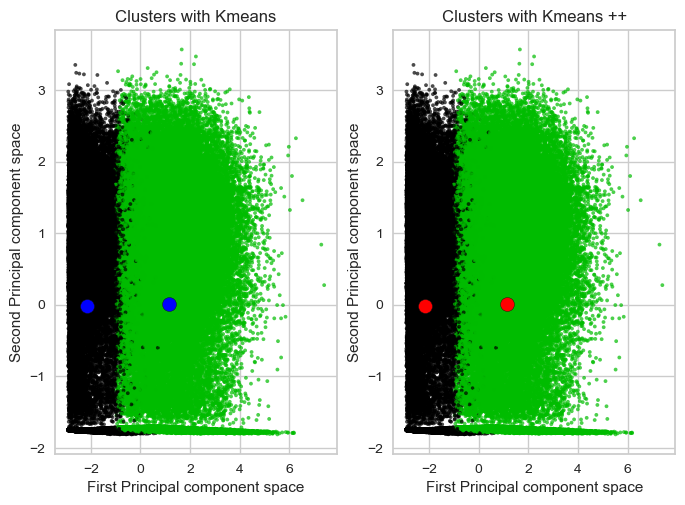

In [52]:
# Scatterplot of the results from Kmeans and Kmeans ++

# Setting plot environment 
data = pd.read_json('reduced9.json', lines=True)
datav = data.values
fig, (ax1, ax2)= plt.subplots(1, 2)

# Kmeans Resuls
# Setting cluster labels for Kmeans
cluster_labels = keys9

# Scatterplot of the data 
ax1.scatter(
            datav[:, 0], datav[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

# Centroids of the kmeans
centers = np.array(centroids, dtype=np.float64)
ax1.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="blue",
    alpha=1,
    s=100,
    edgecolor="k",
)
ax1.set_title('Clusters with Kmeans')
ax1.set_xlabel('First Principal component space')
ax1.set_ylabel('Second Principal component space')


# Kmeans ++ Results
# Setting cluster labels for Kmeans ++
cluster_labels = keys_pp9
# Scatterplot of results from Kmeans ++
ax2.scatter(
            datav[:, 0], datav[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )

# Centroids for Kmeans ++
centers = np.array(centroids_pp, dtype=np.float64)
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="red",
    alpha=1,
    s=100,
    edgecolor="k",
)
ax2.set_title('Clusters with Kmeans ++')
ax2.set_xlabel('First Principal component space')
ax2.set_ylabel('Second Principal component space')

TBD: RESULTS COMPARISON

5. ChatGPT

Text(0, 0.5, 'Second Principal component space')

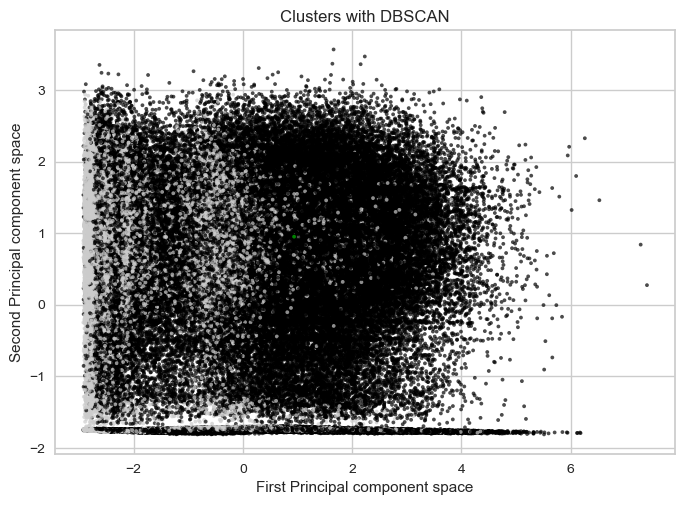

In [41]:
# Load your preprocessed dataset
# Assuming 'data' is your DataFrame with features
# You may need to adjust this based on your specific dataset structure
# For example, select relevant features and handle missing values
data =pd.read_json('reduced9.json', lines=True)


# Create and fit the DBSCAN model
# The eps parameter controls the maximum distance between two samples for one to be considered as in the neighborhood of the other
# The min_samples parameter sets the number of samples (or total weight) in a neighborhood for a point to be considered as a core point
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(data)

# Access the labels assigned to each data point
labels = dbscan.labels_

# Adding labels to the original dataset, not the one resulting from PCA

originaldata = pd.read_json('allvariables.json', lines=True)
originaldata['Cluster_Labels'] = labels

#Scatterplot of the results
datav = data.values
fig, ax2 = plt.subplots(1, 1)

cluster_labels = labels
colors1 = cm.nipy_spectral(labels.astype(float) / n_clusters)

ax2.scatter(
            datav[:, 0], datav[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors1, edgecolor="k"
        )

plt.title('Clusters with DBSCAN')
plt.xlabel('First Principal component space')
plt.ylabel('Second Principal component space')



Data already normalized => no scaling 

In [22]:
originaldata

,favorite_genres,average_click,oldmovie,averagetime_day,timeofday,weekend,count_notenglish,is_series,num_films,onefilm,avg_lentitle,avg_duration,genre_diversity,avg_clickgap,gap_time_avg,Cluster_Labels
0,"[Comedy, Drama, Romance]",0.000000,newmovies,0.000000,Morning,True,0,False,1,False,34,0.000,Not Genre Diverse,NaN,9.0,-1
1,[Adventure],2024.166667,newmovies,44.871296,Afternoon,True,0,True,12,True,15,155.375,Genre Diverse,44.486,5.0,-1
2,[Romance],0.000000,newmovies,0.000000,Afternoon,True,1,True,6,True,13,105.467,Genre Diverse,332.693,4.0,-1
3,[Comedy],0.000000,newmovies,0.000000,Afternoon,True,5,True,15,True,13,31.392,Genre Diverse,214.389,6.0,-1
4,"[Animation, Family, Fantasy, Short, Horror, Mu...",9663.500000,newmovies,143.319444,Afternoon,False,5,True,26,True,14,145.148,Genre Diverse,446.923,6.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161913,"[Comedy, Romance]",8495.000000,newmovies,141.583333,Morning,True,1,False,1,False,18,0.000,Not Genre Diverse,NaN,0.0,-1
161914,"[Biography, Drama, Sport]",1785.000000,newmovies,29.750000,Morning,True,0,False,1,False,14,0.000,Not Genre Diverse,NaN,10.0,-1
161915,"[Animation, Adventure, Comedy, Family, Fantasy...",40606.272727,newmovies,745.945833,Morning,True,0,True,1,False,15,0.000,Genre Diverse,NaN,2.0,-1
161916,"[Biography, Crime, Drama]",0.000000,oldmovies,0.000000,Night,True,0,False,1,True,23,709.867,Not Genre Diverse,NaN,6.0,-1


## 2.4: 2.4 Analysing your results!

![Alt text](image.png)

First variable: *average_click*

In [23]:
dfpivot = dftotal9.copy()
dfpivot = dfpivot[['Cluster', 'average_click']]

average_click_part = dfpivot.average_click.quantile([.25, .5, .75]).values
dfpivot['average_click_first_quantile'] = dfpivot.average_click.apply(lambda row: row <= average_click_part[0] )
dfpivot['average_click_second_quantile'] = dfpivot.average_click.apply(lambda row: (row <= average_click_part[1]) & (row > average_click_part[0]))
dfpivot['average_click_third_quantile'] = dfpivot.average_click.apply(lambda row: (row <= average_click_part[2]) & (row > average_click_part[1]) )
dfpivot['average_click_fourth_quantile'] = dfpivot.average_click.apply(lambda row: row > average_click_part[2] )

pivotpart = dfpivot.groupby('Cluster').agg(list)
takepercentage = lambda l: round(sum(l)/len(l) * 100)
pivotpart.average_click_first_quantile = pivotpart.average_click_first_quantile.apply(takepercentage)
pivotpart.average_click_second_quantile = pivotpart.average_click_second_quantile.apply(takepercentage)
pivotpart.average_click_third_quantile = pivotpart.average_click_third_quantile.apply(takepercentage)
pivotpart.average_click_fourth_quantile = pivotpart.average_click_fourth_quantile.apply(takepercentage)

pivotpart.drop('average_click', axis=1, inplace=True)

pivotpart

,average_click_first_quantile,average_click_second_quantile,average_click_third_quantile,average_click_fourth_quantile
Cluster,,,,
0,32,18,25,25
1,32,18,25,25


2nd variable: *'onefilm'*

In [24]:
dfpivot = dftotal9.copy()
dfpivot = dfpivot[['Cluster', 'onefilm']]

pivotpart = dfpivot.groupby('Cluster').agg(list)
takeproportion = lambda l: sum(l)/len(l)


pivotpart['Only_one_film']= pivotpart.onefilm.apply(lambda x: round(takeproportion(x) * 100))
pivotpart['More_films'] = pivotpart.onefilm.apply(lambda x: round((1 -takeproportion(x)) * 100))

pivotpart.drop('onefilm', axis=1, inplace=True)

pivotpart

,Only_one_film,More_films
Cluster,,
0,7,93
1,100,0


3rd variable: *avg_duration*

In [25]:
dfpivot = dftotal9.copy()
dfpivot = dfpivot[['Cluster', 'avg_duration']]

avg_duration_part = dfpivot.avg_duration.quantile([.25, .5, .75]).values
dfpivot['average_duration_first_quantile'] = dfpivot.avg_duration.apply(lambda row: row <= avg_duration_part[0] )
dfpivot['average_duration_second_quantile'] = dfpivot.avg_duration.apply(lambda row: (row <= avg_duration_part[1]) & (row > avg_duration_part[0]))
dfpivot['average_duration_third_quantile'] = dfpivot.avg_duration.apply(lambda row: (row <= avg_duration_part[2]) & (row > avg_duration_part[1]) )
dfpivot['average_duration_fourth_quantile'] = dfpivot.avg_duration.apply(lambda row: row > avg_duration_part[2] )

pivotpart = dfpivot.groupby('Cluster').agg(list)
takepercentage = lambda l: round(sum(l)/len(l) * 100)
pivotpart.average_duration_first_quantile = pivotpart.average_duration_first_quantile.apply(takepercentage)
pivotpart.average_duration_second_quantile = pivotpart.average_duration_second_quantile.apply(takepercentage)
pivotpart.average_duration_third_quantile = pivotpart.average_duration_third_quantile.apply(takepercentage)
pivotpart.average_duration_fourth_quantile = pivotpart.average_duration_fourth_quantile.apply(takepercentage)

pivotpart.drop('avg_duration', axis=1, inplace=True)

pivotpart

,average_duration_first_quantile,average_duration_second_quantile,average_duration_third_quantile,average_duration_fourth_quantile
Cluster,,,,
0,93,6,1,0
1,0,24,38,38


4th variable: *genre_diversity*

In [56]:
dfpivot = dftotal9.copy()
dfpivot = dfpivot[['Cluster', 'genre_diversity']]
dfpivot

,Cluster,genre_diversity
0,0,Not Genre Diverse
1,1,Genre Diverse
2,1,Genre Diverse
3,1,Genre Diverse
4,1,Genre Diverse
...,...,...
161913,0,Not Genre Diverse
161914,0,Not Genre Diverse
161915,0,Genre Diverse
161916,1,Not Genre Diverse


In [57]:
dfpivot = dftotal9.copy()
dfpivot = dfpivot[['Cluster', 'genre_diversity']]

dfpivot['genre_diversity'] = dfpivot.genre_diversity.apply(lambda row: int(row == 'Genre Diverse'))

pivotpart = dfpivot.groupby('Cluster').agg(list)
takeproportion = lambda l: sum(l)/len(l)

pivotpart['Only_one_genre']= pivotpart.genre_diversity.apply(lambda x: round(takeproportion(x) * 100))
pivotpart['More_genres'] = pivotpart.genre_diversity.apply(lambda x: round((1 -takeproportion(x)) * 100))

pivotpart.drop('genre_diversity', axis=1, inplace=True)

pivotpart

,Only_one_genre,More_genres
Cluster,,
0,25,75
1,63,37
